# import path

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import gc
from pathlib import Path

import os
import os.path
import glob
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential, Input, initializers, optimizers, callbacks
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, ReLU, PReLU
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

seed = 47

# dataset config

In [2]:
images_folder_path = './data/images/'
foods = list(os.walk(images_folder_path))[0][1]

In [3]:
nr_foods = 90

idx_to_name = {i:x for (i,x) in enumerate(foods[:nr_foods])}
name_to_idx = {x:i for (i,x) in enumerate(foods[:nr_foods])}

idx_to_name

{0: 'foie_gras',
 1: 'club_sandwich',
 2: 'cheese_plate',
 3: 'cup_cakes',
 4: 'garlic_bread',
 5: 'gnocchi',
 6: 'ice_cream',
 7: 'samosa',
 8: 'donuts',
 9: 'tuna_tartare',
 10: 'filet_mignon',
 11: 'seaweed_salad',
 12: 'french_toast',
 13: 'chicken_curry',
 14: 'shrimp_and_grits',
 15: 'steak',
 16: 'cheesecake',
 17: 'red_velvet_cake',
 18: 'waffles',
 19: 'churros',
 20: 'gyoza',
 21: 'lobster_roll_sandwich',
 22: 'huevos_rancheros',
 23: 'breakfast_burrito',
 24: 'grilled_cheese_sandwich',
 25: 'spaghetti_bolognese',
 26: 'falafel',
 27: 'poutine',
 28: 'greek_salad',
 29: 'beef_tartare',
 30: 'fried_calamari',
 31: 'guacamole',
 32: 'ravioli',
 33: 'lobster_bisque',
 34: 'beet_salad',
 35: 'risotto',
 36: 'crab_cakes',
 37: 'strawberry_shortcake',
 38: 'edamame',
 39: 'ceviche',
 40: 'hot_and_sour_soup',
 41: 'spring_rolls',
 42: 'sashimi',
 43: 'paella',
 44: 'clam_chowder',
 45: 'miso_soup',
 46: 'escargots',
 47: 'hot_dog',
 48: 'pulled_pork_sandwich',
 49: 'bruschetta',
 50

# working w/ data

In [4]:
data = []
labels = []
img_size = (128, 128)

for food in tqdm(idx_to_name.values()):
    path = images_folder_path
    imgs = [cv2.resize(cv2.imread(img), img_size, interpolation=cv2.INTER_AREA) for img in glob.glob(path + food + '/*.jpg')]
    for img in imgs:
        labels.append(name_to_idx[food])
        data.append(img)
        
data = np.array(data)
data = data / 255.0
data = data.astype('float32')

labels = np.array(labels)
labels = np.eye(len(idx_to_name.keys()))[list(labels)]

100%|██████████| 90/90 [04:34<00:00,  3.05s/it]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    shuffle=True)

del data
del labels
gc.collect()

94

# lifestyle function

In [6]:
def f1(y_true, y_pred): 
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [7]:
def f1(y_true, y_pred): 
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [8]:
def results_plot(history, title):
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="train loss")
    ax[0].plot(history.history['val_loss'], color='r', label="val loss",axes=ax[0])
    legend = ax[0].legend()

    ax[1].plot(history.history['accuracy'], color='b', label="train acc")
    ax[1].plot(history.history['val_accuracy'], color='r',label="val acc")
    
    legend = ax[1].legend()
    ax[0].set_title(title)
    
    plt.plot()

In [9]:
shape = (128, 128, 3)
num_targets = y_train.shape[1]

metrics = ['accuracy', f1, AUC(name='auc')]
fit_params = {
        'x': X_train,
        'y': y_train,
        'validation_data': (X_test, y_test),
        'verbose': 1}

# model part

In [10]:
def base_model(epochs, lr):

    model = Sequential()
    model.add(Input(shape))
    model.add(Flatten())
    model.add(Dense(num_targets, activation='softmax',
           kernel_initializer=initializers.RandomNormal(0, 1, seed=seed)))
    
    model.compile(
        loss=CategoricalCrossentropy(),
        optimizer=optimizers.SGD(learning_rate=lr),
        metrics=metrics)
    
    history = model.fit(**fit_params,
                        epochs=epochs)
    del model
    gc.collect()
    
    return history

In [11]:
base_model_history = base_model(epochs=10, lr=0.01)

Epoch 1/10
2250/2250 [==============================] - 53s 23ms/step - loss: 121.0908 - accuracy: 0.0133 - f1: 0.0133 - auc: 0.5014 - val_loss: 88.3612 - val_accuracy: 0.0182 - val_f1: 0.0181 - val_auc: 0.5047
Epoch 2/10
2250/2250 [==============================] - 45s 20ms/step - loss: 84.6353 - accuracy: 0.0192 - f1: 0.0192 - auc: 0.5054 - val_loss: 78.3718 - val_accuracy: 0.0226 - val_f1: 0.0225 - val_auc: 0.5074
Epoch 3/10
2250/2250 [==============================] - 46s 21ms/step - loss: 75.3827 - accuracy: 0.0226 - f1: 0.0226 - auc: 0.5080 - val_loss: 72.8707 - val_accuracy: 0.0241 - val_f1: 0.0239 - val_auc: 0.5086
Epoch 4/10
2250/2250 [==============================] - 45s 20ms/step - loss: 69.8747 - accuracy: 0.0260 - f1: 0.0260 - auc: 0.5105 - val_loss: 69.2304 - val_accuracy: 0.0247 - val_f1: 0.0247 - val_auc: 0.5094
Epoch 5/10
2250/2250 [==============================] - 46s 20ms/step - loss: 65.9076 - accuracy: 0.0280 - f1: 0.0278 - auc: 0.5117 - val_loss: 66.3070 - val_a

In [12]:
# def tanh_model(epochs, lr):

#     model = Sequential()
#     model.add(Input(shape))
#     model.add(Flatten())
#     model.add(Dense(256,
#                     activation='tanh',
#                     kernel_initializer=initializers.GlorotNormal()))
#     model.add(Dense(64,
#                     activation='tanh',
#                     kernel_initializer=initializers.GlorotNormal()))
#     model.add(Dense(num_targets,
#                     activation='softmax',
#                     kernel_initializer=initializers.RandomNormal(0, 1, seed=seed)))
    
#     model.compile(
#         loss=CategoricalCrossentropy(),
#         optimizer=optimizers.SGD(learning_rate=lr),
#         metrics=metrics)
    
#     history = model.fit(**fit_params,
#                         epochs=epochs,
#                              )
#     del model
#     gc.collect()
    
#     return history

In [13]:
# tanh_model_history = tanh_model(epochs=10, lr=0.01)

In [14]:
# def relu_model(epochs, lr):

#     model = Sequential()
#     model.add(Input(shape))
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu',
#            kernel_initializer=initializers.HeNormal()))
#     model.add(Dense(64, activation='relu',
#            kernel_initializer=initializers.HeNormal()))
#     model.add(Dense(num_targets, activation='softmax',
#            kernel_initializer=initializers.RandomNormal(0, 1, seed=seed)))
    
#     model.compile(
#         loss=CategoricalCrossentropy(),
#         optimizer=optimizers.SGD(learning_rate=lr),
#         metrics=metrics)
    
#     history = model.fit(**fit_params,
#                         epochs=epochs,
#                              )
#     del model
#     gc.collect()
    
#     return history

In [15]:
# relu_model_history = relu_model(epochs=10, lr=0.01)

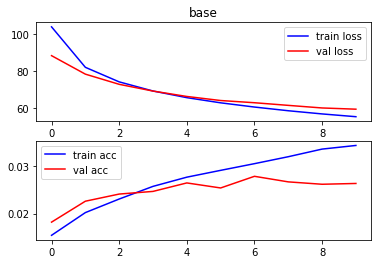

In [16]:
results_plot(base_model_history, 'base')
# results_plot(tanh_model_history, 'tanh')
# results_plot(relu_model_history, 'relu')

In [17]:
# def tune_sgd(lr_list):
    
#     results = pd.DataFrame()
    
#     for lr in lr_list:
#         relu_model_history = tanh_model(epochs=10, lr=lr)
#         results[f'lr {lr}'] = pd.Series({k:v[-1] for k, v in relu_model_history.history.items()})
    
#     return results

In [18]:
# results_tune_sgd = tune_sgd([0.01, 0.005, 0.001])

In [19]:
# results_tune_sgd

In [20]:
# def compare_activations(activations_list):
    
#     results = pd.DataFrame()
#     for act in activations_list:
#         model = Sequential()
#         model.add(Input(shape))
#         model.add(Flatten())
#         model.add(Dense(256, activation=list(act.values())[0]))
#         model.add(Dense(64, activation='tanh'))
#         model.add(Dense(num_targets, activation='softmax',
#                kernel_initializer=initializers.RandomNormal(0, 1, seed=seed)))

#         model.compile(
#             loss=CategoricalCrossentropy(),
#             optimizer=optimizers.SGD(learning_rate=0.001),
#             metrics=metrics)
        
#         start = time.time()
#         history = model.fit(**fit_params,
#                             epochs=10)
#         end = time.time()
        
#         del model
#         gc.collect()
        
#         results[f'{list(act)[0]}'] = pd.concat([pd.Series({'time': end - start}), pd.Series({k:v[-1] for k, v in history.history.items()})])
        
#     return results

In [21]:
# activations_list = [
#     {'prelu': tf.keras.layers.PReLU()},
#     {'leaky_relu': tf.keras.layers.LeakyReLU()}, 
#     {'elu': tf.keras.layers.ELU()}
#                    ]

# results_compare_activations = compare_activations(activations_list)

In [22]:
# results_compare_activations

In [23]:
# def compare_optimizers(optimizers_list):
    
#     results = pd.DataFrame()
#     for opt in optimizers_list:
        
#         model = Sequential()
#         model.add(Input(shape))
#         model.add(Flatten())
#         model.add(Dense(256,
#                         activation='tanh',
#                         kernel_initializer=initializers.GlorotNormal()))
#         model.add(Dense(64,
#                         activation='tanh',
#                         kernel_initializer=initializers.GlorotNormal()))
#         model.add(Dense(num_targets,
#                         activation='softmax',
#                         kernel_initializer=initializers.RandomNormal(0, 1, seed=seed)))

#         model.compile(
#             loss=CategoricalCrossentropy(),
#             optimizer=list(opt.values())[0],
#             metrics=metrics)
        
#         start = time.time()
#         history = model.fit(**fit_params,
#                             epochs=10)
#         end = time.time()
        
#         del model
#         gc.collect()
        
#         results[f'{list(opt)[0]}'] = pd.concat([pd.Series({'time': end - start}), pd.Series({k:v[-1] for k, v in history.history.items()})])
        
#     return results

In [24]:
# results_compare_optimizers = compare_optimizers([{'Nesterov': optimizers.SGD(nesterov=True)},
#                                                  {'Adagrad': optimizers.Adagrad()},
#                                                  {'Adadelta': optimizers.Adadelta()},
#                                                  {'Adam': optimizers.Adam()}])

In [25]:
# results_compare_optimizers

In [26]:
# def batch_norm_model(epochs, lr):
    
        
#     model = Sequential()
#     model.add(Input(shape))
#     model.add(Flatten())
#     model.add(BatchNormalization())
#     model.add(Dense(256,
#                     activation='tanh',
#                     kernel_initializer=initializers.GlorotNormal()))
#     model.add(BatchNormalization())
#     model.add(Dense(64,
#                     activation='tanh',
#                     kernel_initializer=initializers.GlorotNormal()))
#     model.add(BatchNormalization())
#     model.add(Dense(num_targets,
#                     activation='softmax',
#                     kernel_initializer=initializers.RandomNormal(0, 1, seed=seed)))

#     model.compile(
#         loss=CategoricalCrossentropy(),
#         optimizer=optimizers.Adagrad(learning_rate=lr),
#         metrics=metrics)

#     history = model.fit(**fit_params,
#                         epochs=epochs)
#     del model
#     gc.collect()
    
#     return history

In [27]:
# results_batch_norm1 = batch_norm_model(epochs=10, lr=0.001)
# results_batch_norm2 = batch_norm_model(epochs=10, lr=0.05)

In [28]:
# results_plot(results_batch_norm1, 'batchnorm + lr 0.001')
# results_plot(results_batch_norm2, 'batchnorm + lr 0.05')

In [29]:
# def dropout_model(epochs, p):
    
        
#     model = Sequential()
#     model.add(Input(shape))
#     model.add(Flatten())
#     model.add(Dense(256,
#                     activation='tanh',
#                     kernel_initializer=initializers.GlorotNormal()))
#     model.add(Dense(64,
#                     activation='tanh',
#                     kernel_initializer=initializers.GlorotNormal()))
#     model.add(Dropout(p))
#     model.add(Dense(num_targets,
#                     activation='softmax',
#                     kernel_initializer=initializers.RandomNormal(0, 1, seed=seed)))

#     model.compile(
#         loss=CategoricalCrossentropy(),
#         optimizer=optimizers.SGD(learning_rate=0.001),
#         metrics=metrics)

#     history = model.fit(**fit_params,
#                         epochs=epochs)
#     del model
#     gc.collect()
    
#     return history

In [30]:
# dropout_model1 = dropout_model(epochs=10, p=0.1)
# dropout_model0 = dropout_model(epochs=10, p=0.25)
# dropout_model2 = dropout_model(epochs=10, p=0.5)

In [31]:
# results_plot(dropout_model0, 'dropout 0.1')
# results_plot(dropout_model1, 'dropout 0.25')
# results_plot(dropout_model2, 'dropout 0.5')

In [32]:
# def early_stopping_model(epochs):
    
#     model = Sequential()
#     model.add(Input(shape))
#     model.add(Flatten())
#     model.add(Dense(256,
#                     activation='tanh',
#                     kernel_initializer=initializers.GlorotNormal()))
#     model.add(Dense(64,
#                     activation='tanh',
#                     kernel_initializer=initializers.GlorotNormal()))
#     model.add(Dense(num_targets,
#                     activation='softmax',
#                     kernel_initializer=initializers.RandomNormal(0, 1, seed=seed)))
#     model.compile(
#         loss=CategoricalCrossentropy(),
#         optimizer=optimizers.SGD(learning_rate=0.001),
#         metrics=metrics)

#     history = model.fit(**fit_params,
#                         epochs=epochs,
#                         callbacks=[
#                             EarlyStopping(
#                                 monitor='val_loss',
#                                 mode='min',
#                                 patience=5)
#                         ]
#                        )
#     del model
#     gc.collect()
    
#     return history

In [33]:
# early_stopping_res = early_stopping_model(10)

In [34]:
# results_plot(early_stopping_res, 'early stopping model')

In [35]:
# def compare_regularization(regularization_list):
    
#     results = pd.DataFrame()
#     for regularization in regularization_list:
        
#         model = Sequential()
#         model.add(Input(shape))
#         model.add(Flatten())
#         model.add(Dense(256,
#                         activation='tanh',
#                         kernel_initializer=initializers.GlorotNormal(),
#                         kernel_regularizer=regularization,
#                         bias_regularizer=regularization))
#         model.add(Dense(64,
#                         activation='tanh',
#                         kernel_initializer=initializers.GlorotNormal(),
#                         kernel_regularizer=regularization,
#                         bias_regularizer=regularization))
#         model.add(Dense(num_targets,
#                         activation='softmax',
#                         kernel_initializer=initializers.RandomNormal(0, 1, seed=seed),
#                         kernel_regularizer=regularization,
#                         bias_regularizer=regularization))

#         model.compile(
#             loss=CategoricalCrossentropy(),
#             optimizer=optimizers.SGD(learning_rate=0.001),
#             metrics=metrics)
        
#         history = model.fit(**fit_params,
#                             epochs=10)
#         del model
        
#         results[regularization] = pd.Series({k:v[-1] for k, v in history.history.items()})
        
#     return results

In [36]:
# reg_results = compare_regularization(['l1', 'l2', 'l1_l2'])

In [37]:
# reg_results

In [38]:
def final_model():
    model = Sequential()
    model.add(Input(shape))
    model.add(Flatten())
    model.add(Dense(256,
                    activation='tanh',
                    kernel_initializer=initializers.GlorotNormal())
                    )
    model.add(Dense(64,
                    activation='tanh',
                    kernel_initializer=initializers.GlorotNormal())
                    )
    model.add(Dense(num_targets,
                    activation='softmax',
                    kernel_initializer=initializers.RandomNormal(0, 1, seed=seed))
                    )

    model.compile(
        loss=CategoricalCrossentropy(),
        optimizer=optimizers.SGD(learning_rate=0.001),
        metrics=metrics)

    return model

In [39]:
model = final_model()
history = model.fit(**fit_params,
                    epochs=12,
                    callbacks=[EarlyStopping(patience=3)])

Epoch 1/12
2250/2250 [==============================] - 83s 37ms/step - loss: 6.2851 - accuracy: 0.0133 - f1: 5.2463e-04 - auc: 0.5114 - val_loss: 5.1737 - val_accuracy: 0.0234 - val_f1: 7.5354e-04 - val_auc: 0.5378
Epoch 2/12
2250/2250 [==============================] - 82s 36ms/step - loss: 5.0804 - accuracy: 0.0235 - f1: 7.5286e-04 - auc: 0.5445 - val_loss: 4.8890 - val_accuracy: 0.0281 - val_f1: 6.4589e-04 - val_auc: 0.5511
Epoch 3/12
2250/2250 [==============================] - 82s 36ms/step - loss: 4.8250 - accuracy: 0.0295 - f1: 0.0030 - auc: 0.5656 - val_loss: 4.7506 - val_accuracy: 0.0326 - val_f1: 0.0032 - val_auc: 0.5707
Epoch 4/12
2250/2250 [==============================] - 82s 36ms/step - loss: 4.6530 - accuracy: 0.0385 - f1: 0.0054 - auc: 0.5914 - val_loss: 4.6507 - val_accuracy: 0.0336 - val_f1: 0.0030 - val_auc: 0.5821
Epoch 5/12
2250/2250 [==============================] - 83s 37ms/step - loss: 4.5493 - accuracy: 0.0425 - f1: 0.0070 - auc: 0.6099 - val_loss: 4.5862 - 

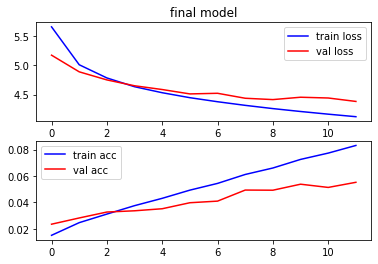

In [40]:
results_plot(history, 'final model')

# confusion matrix

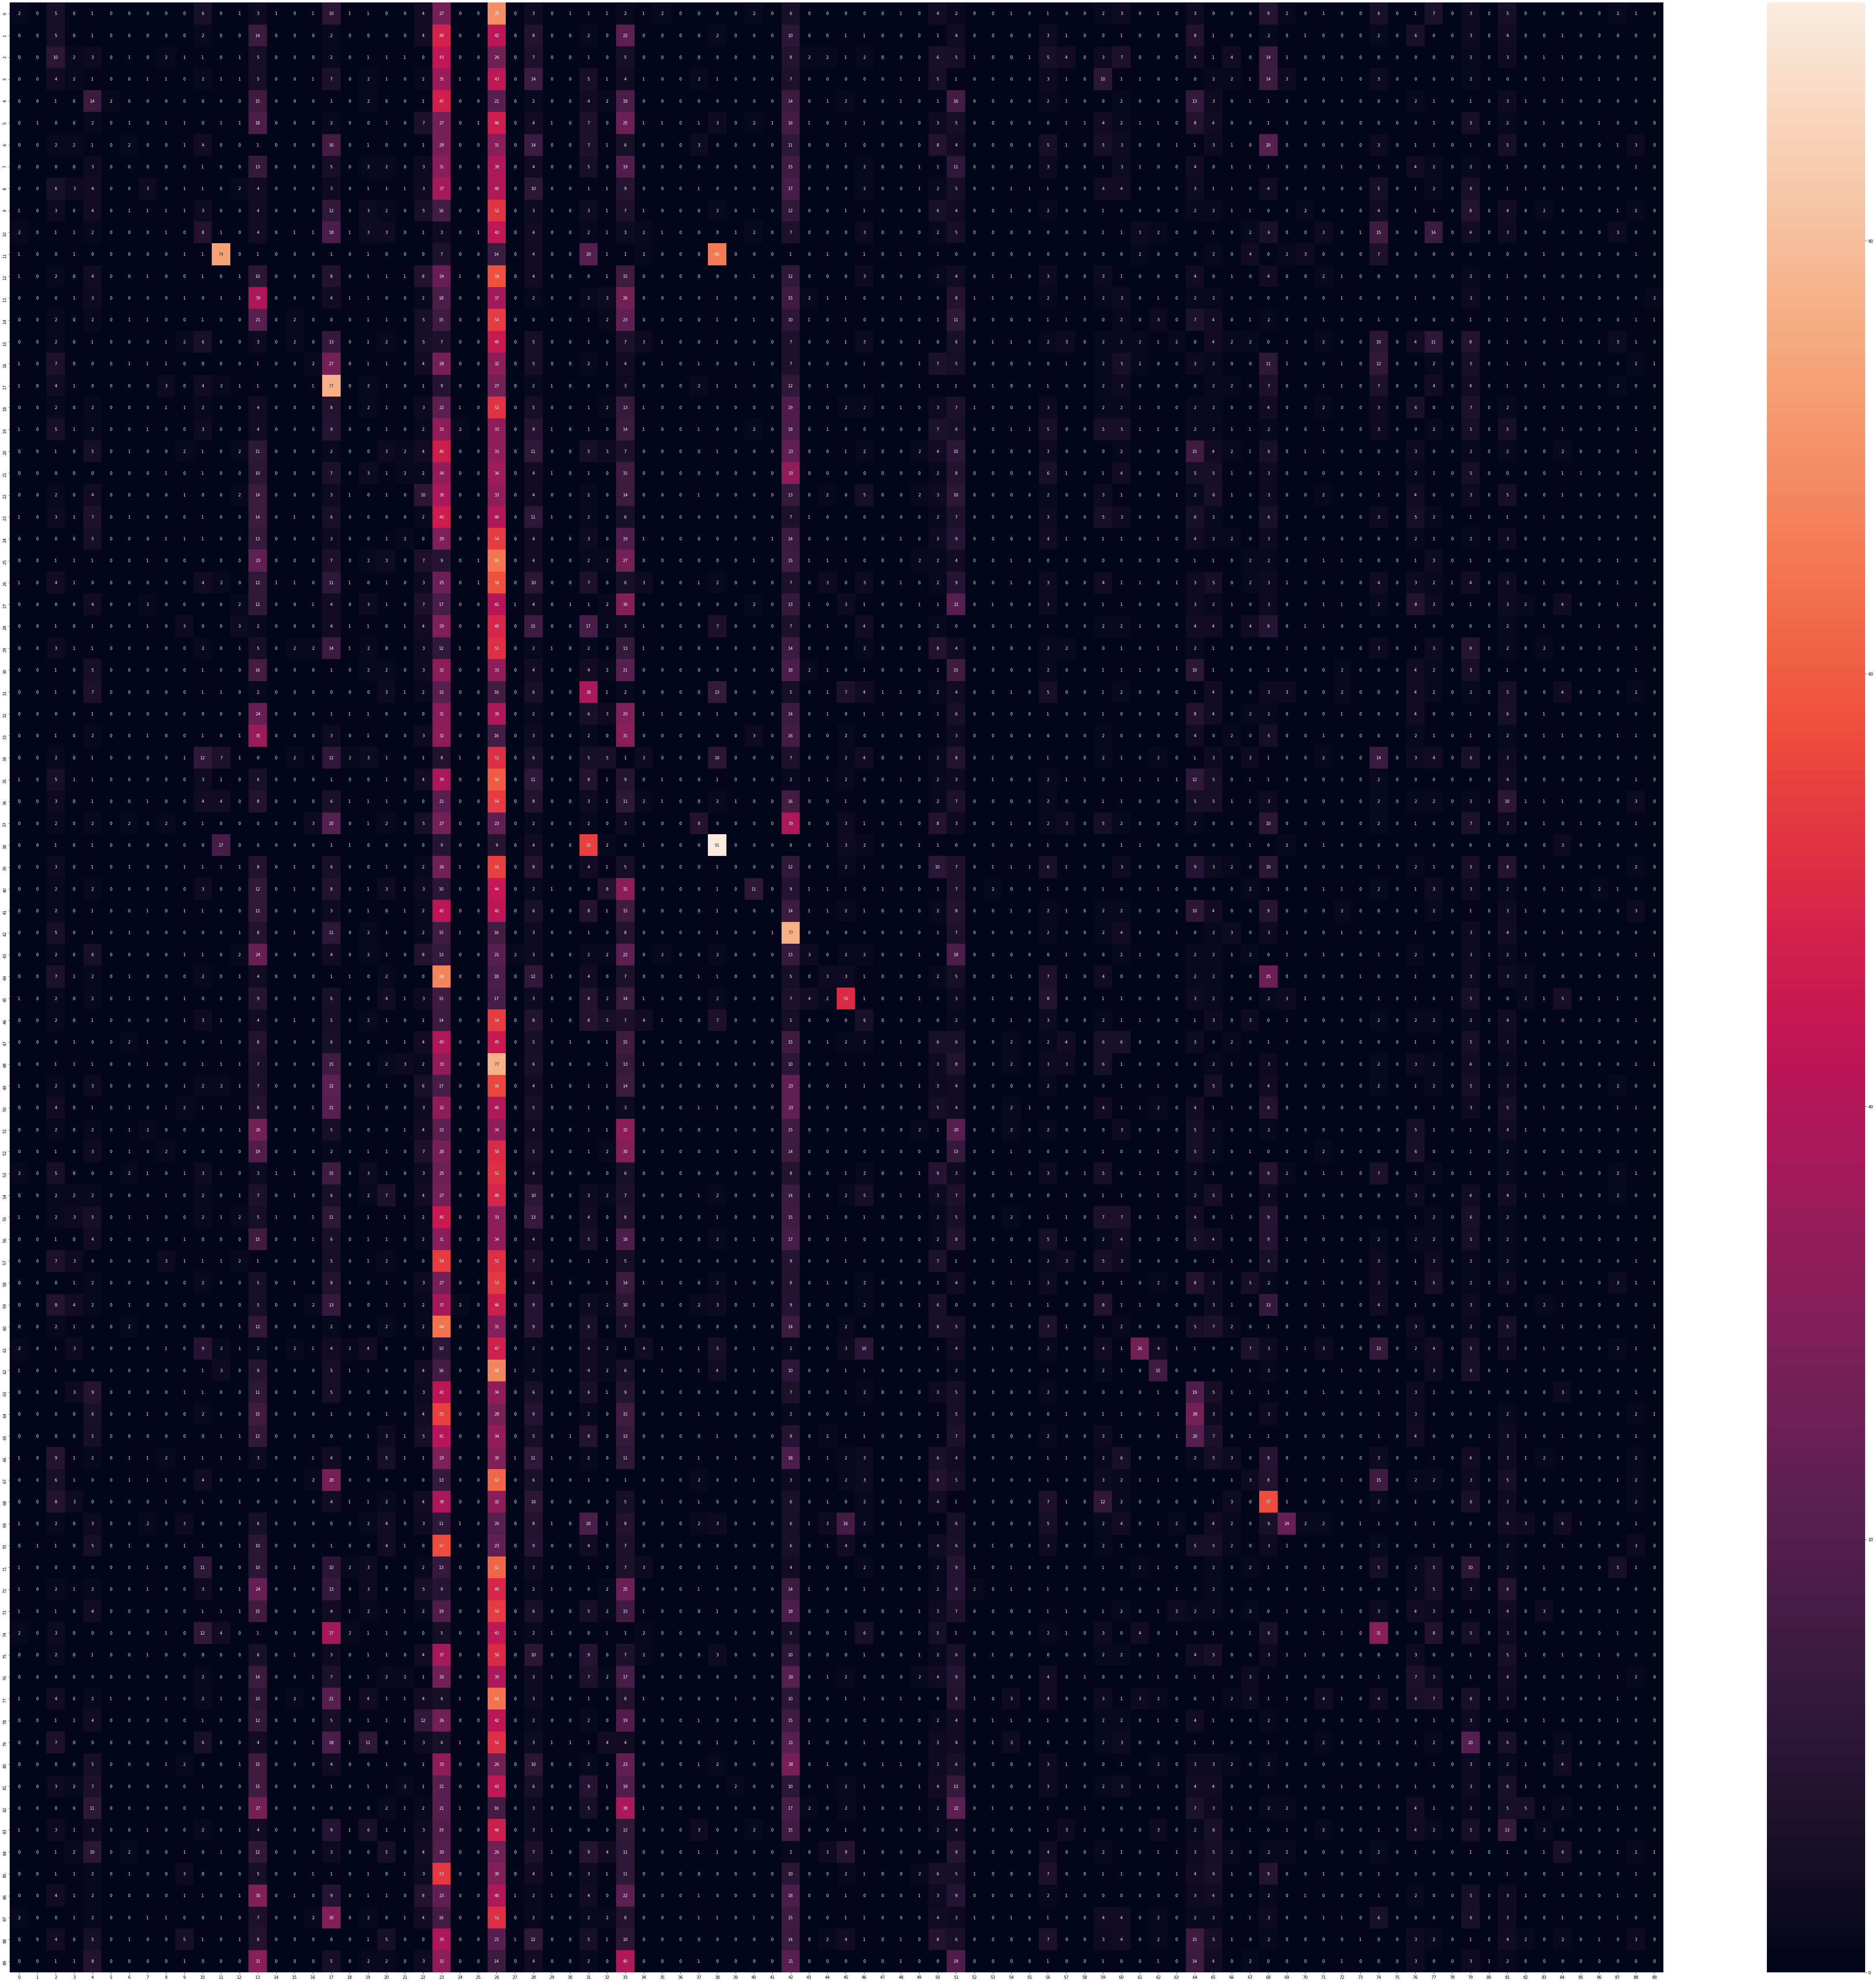

In [41]:
ypred = np.argmax(model.predict(X_test),axis=1)
ytest = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(ytest, ypred)

plt.figure(figsize=(num_targets+2,num_targets))
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


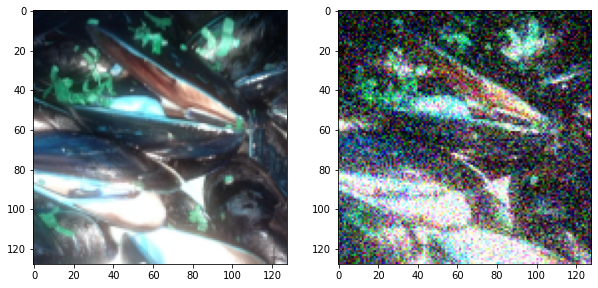

In [42]:
X_new = X_test[seed]
noise = np.random.normal(0, .2, X_new.shape)
X_new_noise = X_new + noise
pict = [X_new, X_new_noise]

plt.figure(figsize = (10,10))
colums, row = 1, 2

for i in range(2):  
    plt.subplot(colums, row, i + 1)
    plt.imshow(pict[i], cmap='Greys')
    
plt.show()

In [43]:
ypred_new = model.predict(X_new.reshape(-1,128,128,3))
ypred_new_val = np.argmax(ypred_new, axis=1)

ypred_new_noise = model.predict(X_new_noise.reshape(-1,128,128,3))
ypred_new_noise_val = np.argmax(ypred_new_noise, axis=1)

print(f'Predicted class w/out noise: {ypred_new_val}, w/ noise {ypred_new_noise_val}')

Predicted class w/out noise: [81], w/ noise [81]


In [44]:
X_new

array([[[0.02352941, 0.05098039, 0.10588235],
        [0.02745098, 0.05490196, 0.10196079],
        [0.03529412, 0.05490196, 0.09803922],
        ...,
        [0.01568628, 0.03921569, 0.08627451],
        [0.00784314, 0.03137255, 0.07843138],
        [0.02745098, 0.04705882, 0.09411765]],

       [[0.03137255, 0.05098039, 0.09019608],
        [0.02745098, 0.04705882, 0.09019608],
        [0.03529412, 0.0627451 , 0.11372549],
        ...,
        [0.02352941, 0.03921569, 0.08235294],
        [0.00392157, 0.03529412, 0.07450981],
        [0.02352941, 0.0627451 , 0.10196079]],

       [[0.03137255, 0.05490196, 0.10196079],
        [0.03137255, 0.05882353, 0.10980392],
        [0.03921569, 0.07058824, 0.1254902 ],
        ...,
        [0.01960784, 0.03529412, 0.07058824],
        [0.01176471, 0.03921569, 0.07450981],
        [0.01960784, 0.05490196, 0.09019608]],

       ...,

       [[0.14901961, 0.1764706 , 0.23529412],
        [0.16078432, 0.1882353 , 0.23921569],
        [0.16470589, 0

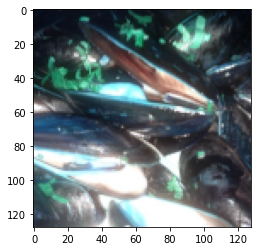

In [45]:
plt.imshow(X_new)

In [46]:
ypred_new = model.predict(X_new.reshape(-1,128,128,3))
ypred_new

array([[0.00175144, 0.00022144, 0.01112722, 0.00518603, 0.00147146,
        0.00148241, 0.00704418, 0.0029754 , 0.00955178, 0.0109021 ,
        0.07360829, 0.00120391, 0.00125224, 0.01134751, 0.00131398,
        0.0121936 , 0.00392505, 0.02376713, 0.0090607 , 0.01154591,
        0.00077665, 0.00455169, 0.0039135 , 0.00438633, 0.0033724 ,
        0.00729707, 0.01970201, 0.00559025, 0.00802587, 0.01143222,
        0.00237978, 0.00188964, 0.0006371 , 0.0078696 , 0.02715536,
        0.00360108, 0.00304104, 0.00048294, 0.00496788, 0.00498209,
        0.00146705, 0.0036403 , 0.00402133, 0.00098287, 0.00399093,
        0.00105142, 0.00593385, 0.00425644, 0.00045628, 0.03679402,
        0.01173755, 0.00975016, 0.00281461, 0.01958119, 0.03004294,
        0.0031434 , 0.03561784, 0.01159903, 0.00888798, 0.00266466,
        0.01539016, 0.00133504, 0.00812523, 0.00144759, 0.00420883,
        0.01756415, 0.00838163, 0.0219617 , 0.03601447, 0.00138209,
        0.003667  , 0.0081553 , 0.00412291, 0.02

In [47]:
ypred_new_val = np.argmax(ypred_new, axis=1)
ypred_new_val

array([81])

In [49]:
model.save("food_classification_model.h5")